<a href="https://colab.research.google.com/github/Susmithareddya/LSTM/blob/main/Predictive_Modeling_of_Weather_Data_Using_LSTM_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from zipfile import ZipFile
import seaborn as sns

In [2]:
# Download and extract the dataset
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_path)

# View the first few rows of the DataFrame
print(df.head())

# Select Date Time and T (degC) columns
#temperature_data = df[['Date Time', 'T (degC)']]

# Now you have a DataFrame containing both Date Time and Temperature
#print(temperature_data.head())  # Print first few rows for verification


13568290/13568290 [==============================] - 0s 0us/step
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


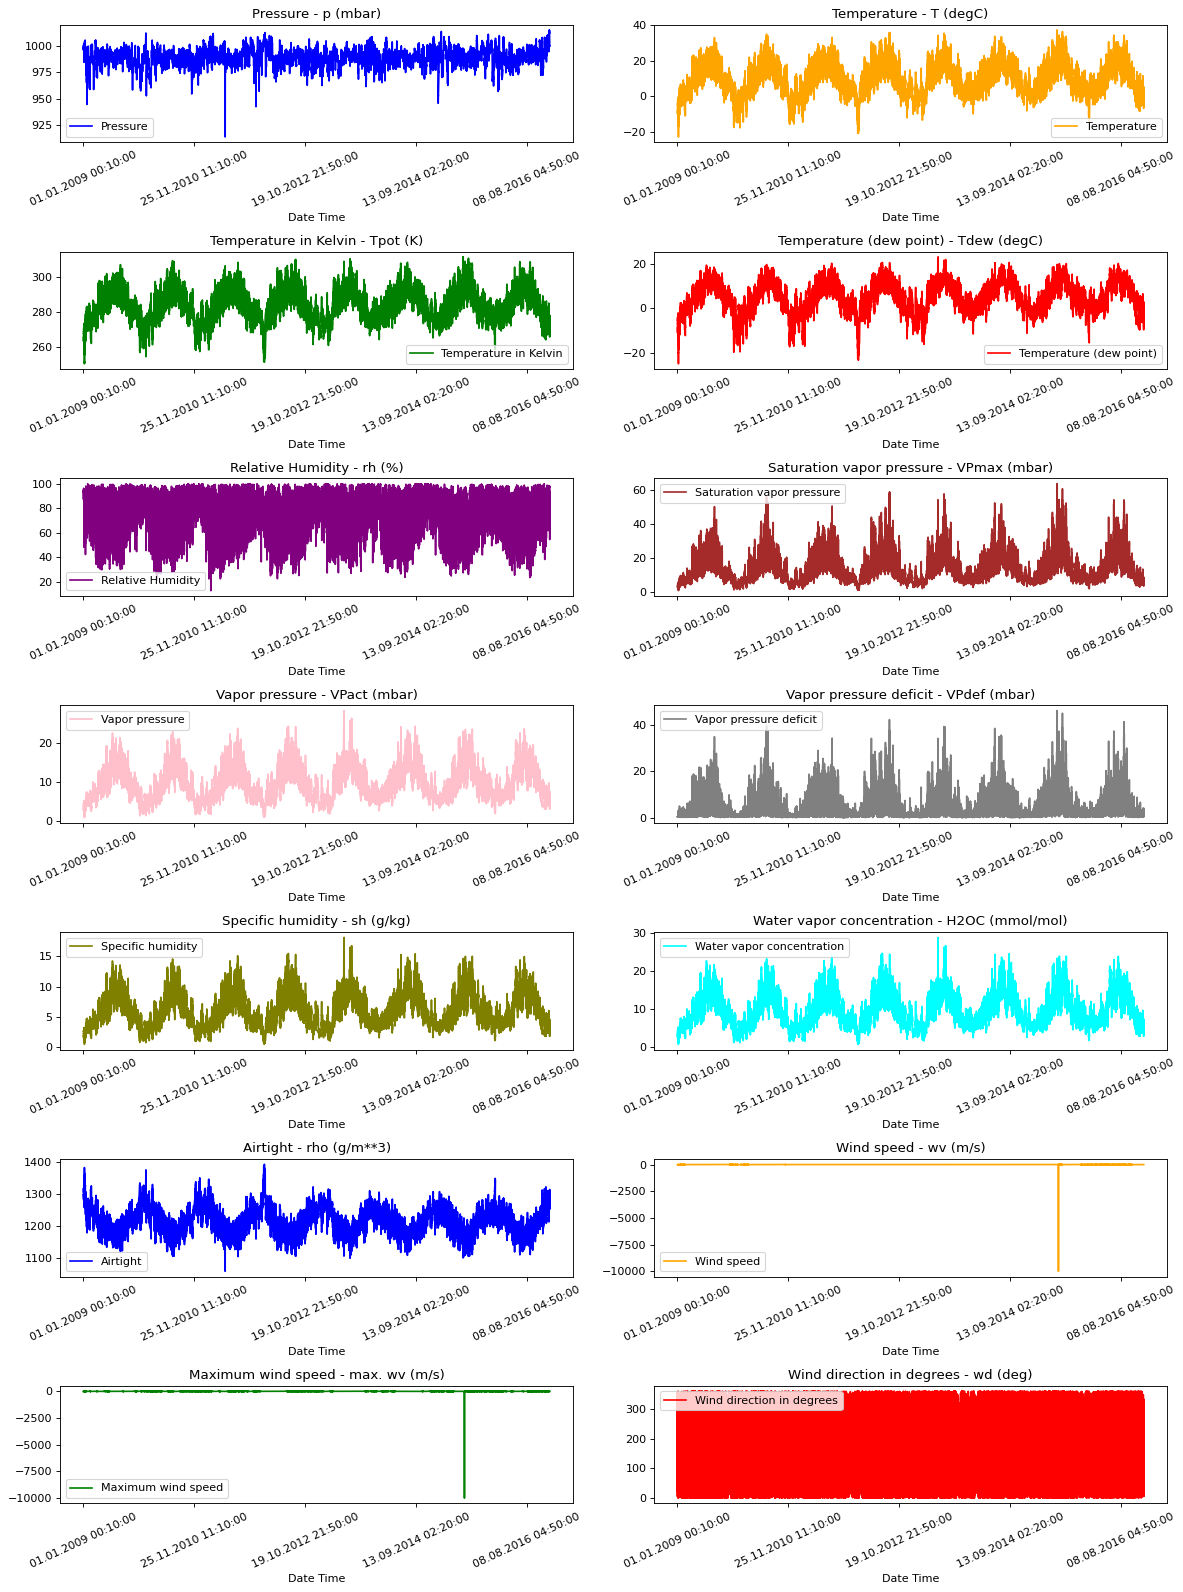

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)


In [4]:
# Select the relevant columns for correlation
selected_columns = feature_keys

# Compute the correlation matrix
correlation_matrix = df[selected_columns].corr()


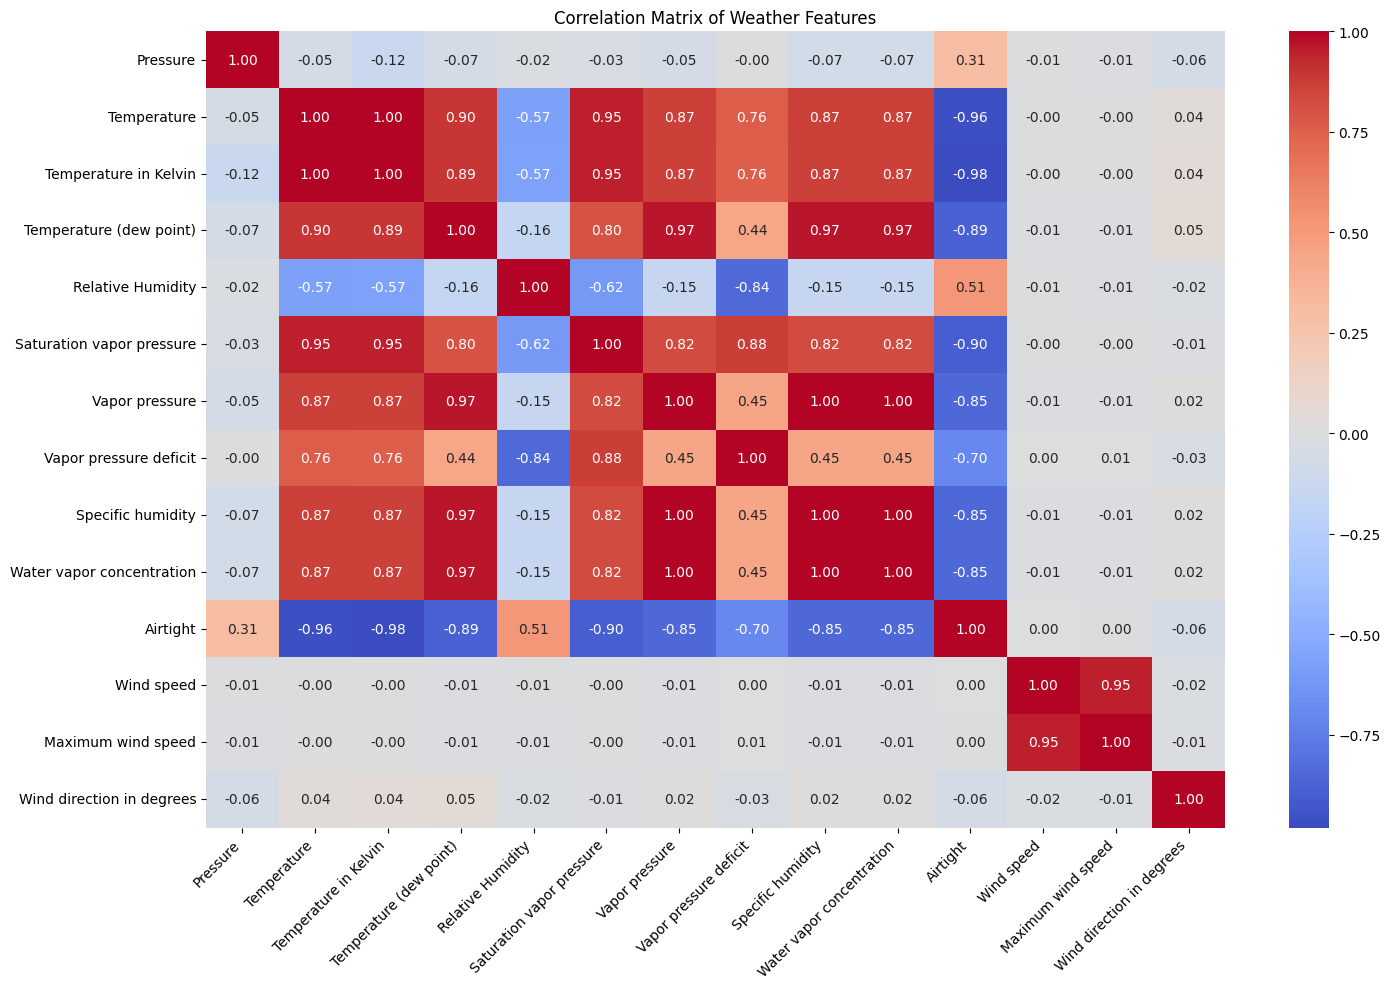

In [7]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=titles, yticklabels=titles)

# Add title and adjust layout
plt.title('Correlation Matrix of Weather Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()


In [9]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [10]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [1,8]]),
)
selected_features = [feature_keys[i] for i in [1,8]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Temperature, Specific humidity


In [11]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(2)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [12]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [13]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(2)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 2)
Target shape: (256, 1)


In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 120, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1680
Epoch 1: val_loss improved from inf to 0.14815, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 130s 108ms/step - loss: 0.1680 - val_loss: 0.1481
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1323
Epoch 2: val_loss improved from 0.14815 to 0.14448, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 125s 107ms/step - loss: 0.1323 - val_loss: 0.1445
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1280
Epoch 3: val_loss improved from 0.14448 to 0.14365, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 125s 106ms/step - loss: 0.1280 - val_loss: 0.1436
Epoch 4/10
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1256
Epoch 4: val_loss improved from 0.14365 to 0.14326, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 107s 91ms/step - loss: 0.1257 - val_loss: 0.1433
Epoch 5/10
1172/1

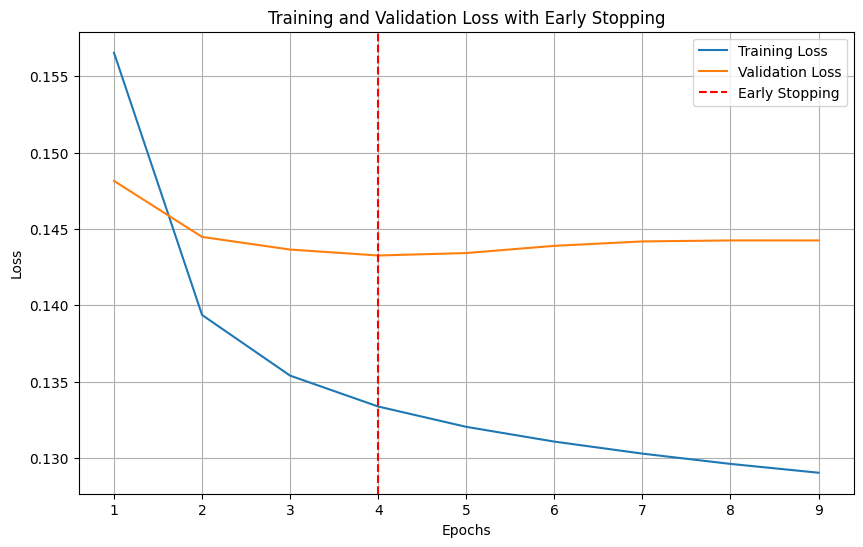

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss')
plt.plot(np.arange(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')

# Find the epoch at which training stopped
stopped_epoch = es_callback.stopped_epoch
if stopped_epoch > 0:
    plt.axvline(x=stopped_epoch - es_callback.patience + 1, color='r', linestyle='--', label='Early Stopping')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Early Stopping')
plt.legend()
plt.grid(True)

# Adjust x-axis ticks
plt.xticks(np.arange(1, len(history.history['loss']) + 1))

plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


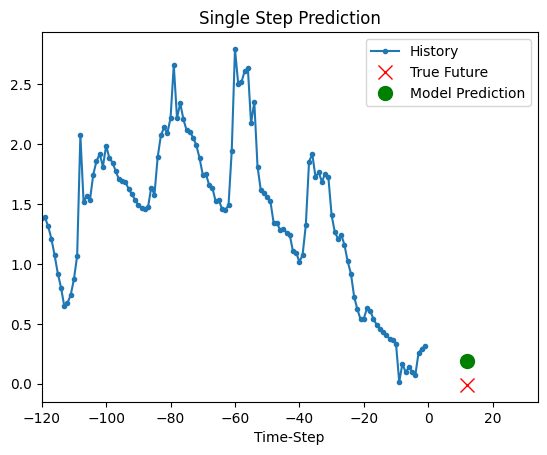

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


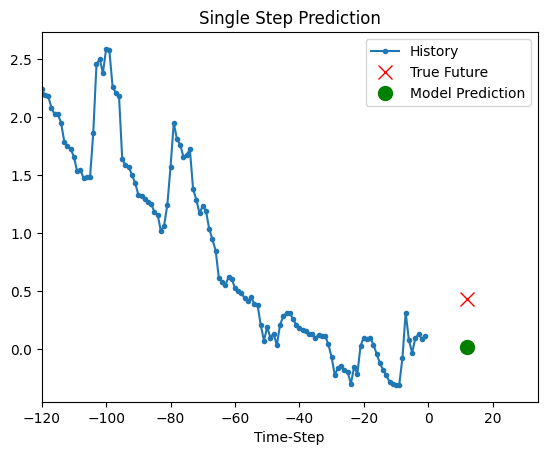

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


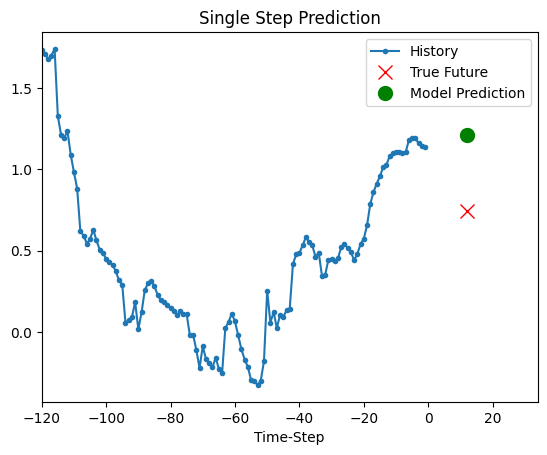

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


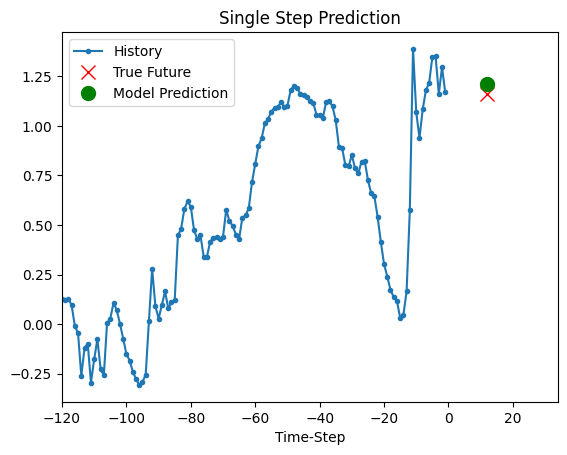

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


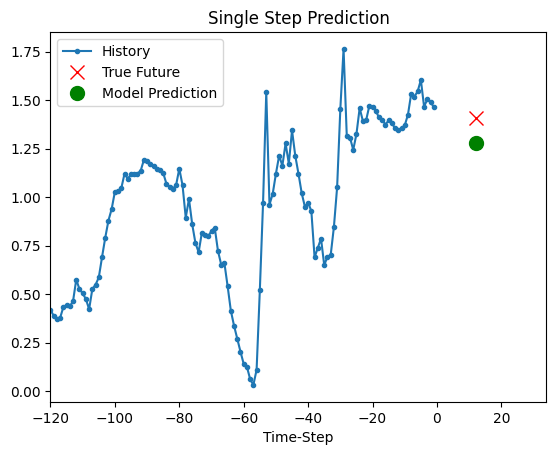

In [ ]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [ ]:
# Retrieve the MSE losses from history
training_mse = history.history['loss'][3]  # Training MSE at 8th epoch (index 7, since indexing starts at 0)
validation_mse = history.history['val_loss'][3]  # Validation MSE at 8th epoch

# Print the MSE losses at the 8th epoch
print(f"Training MSE at 8th epoch: {training_mse}")
print(f"Validation MSE at 8th epoch: {validation_mse}")

Training MSE at 8th epoch: 0.13336636126041412
Validation MSE at 8th epoch: 0.1432608962059021
